In [82]:
import os
import pickle
import imageio
from pathlib import Path

# import the necessary packages
from collections import OrderedDict

import matplotlib.pyplot as plt
%matplotlib inline

from mlxtend.image import extract_face_landmarks

import dlib

import numpy as np

In [83]:
import dlib
import cv2

In [84]:
FACIAL_LANDMARKS_68_IDXS = OrderedDict([
    ("mouth", (48, 68)),
    ("inner_mouth", (60, 68)),
    ("right_eyebrow", (17, 22)),
    ("left_eyebrow", (22, 27)),
    ("right_eye", (36, 42)),
    ("left_eye", (42, 48)),
    ("nose", (27, 36)),
    ("jaw", (0, 17))
])

In [109]:
def rect_to_bb(rect):
    # take a bounding predicted by dlib and convert it
    # to the format (x, y, w, h) as we would normally do
    # with OpenCV
    x = rect.left()
    y = rect.top()
    w = rect.right() - x
    h = rect.bottom() - y
    # return a tuple of (x, y, w, h)
    return (x, y, w, h)

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((68, 2), dtype=dtype)
    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, 68):
        coords[i] = (shape.part(i).x, shape.part(i).y)
    # return the list of (x, y)-coordinates
    return coords

In [110]:
lfw2_crop = os.path.join('..', 'Data', 'lfw2_cropped')
putin_01 = Path(lfw2_crop, 'Vladimir_Putin', 'Vladimir_Putin_0001.jpg')
img = plt.imread(putin_01)

In [178]:
putin_21 = Path(lfw2_crop, 'Vladimir_Putin', 'Vladimir_Putin_0021.jpg')
img2 = plt.imread(putin_21)

In [111]:
# img = plt.imread(putin_01)
# predictor = dlib.shape_predictor(args["shape_predictor"])
# shape = predictor(img)
# print(shape.shape)
# print('\n\nFirst 10 landmarks:\n', shape[:10])

In [112]:

landmarks = extract_face_landmarks(img)
print(landmarks.shape)
print('\n\nFirst 10 landmarks:\n', landmarks[:10])

(68, 2)


First 10 landmarks:
 [[ 12  30]
 [ 13  43]
 [ 15  55]
 [ 18  66]
 [ 21  77]
 [ 26  86]
 [ 33  95]
 [ 41 101]
 [ 53 102]
 [ 66 102]]


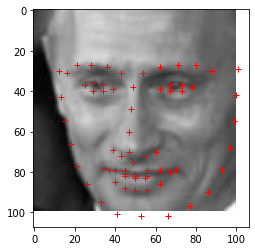

In [119]:
fig, ax = plt.subplots(1)
ax.imshow(img, cmap='gray')
for i, (x,y) in enumerate(landmarks):
    ax.plot(x, y, 'r+')
#     ax.annotate(text=str(i), xy=(x,y))

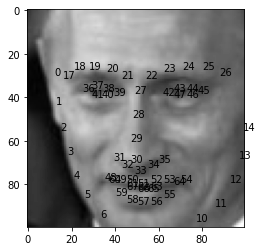

In [120]:
fig, ax = plt.subplots(1)
ax.imshow(img, cmap='gray')
for i, (x,y) in enumerate(landmarks):
#     ax.plot(x, y, 'r+')
    ax.annotate(text=str(i), xy=(x,y))

In [147]:
# extract the left and right eye (x, y)-coordinates
(lStart, lEnd) = FACIAL_LANDMARKS_68_IDXS["left_eye"]
print((lStart, lEnd))
(rStart, rEnd) = FACIAL_LANDMARKS_68_IDXS["right_eye"]
print((rStart, rEnd))


(42, 48)
(36, 42)


In [148]:
leftEyePts = landmarks[lStart:lEnd]
rightEyePts = landmarks[rStart:rEnd]

In [149]:
# compute the center of mass for each eye
leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

In [150]:
# compute the angle between the eye centroids
dY = rightEyeCenter[1] - leftEyeCenter[1]
dX = rightEyeCenter[0] - leftEyeCenter[0]
angle = np.degrees(np.arctan2(dY, dX)) - 180

In [151]:
desiredLeftEye=(0.35, 0.35)
desiredFaceWidth=100
desiredFaceHeight=100

In [152]:
# compute the desired right eye x-coordinate based on the
# desired x-coordinate of the left eye
desiredRightEyeX = 1.0 - desiredLeftEye[0]

In [160]:
# determine the scale of the new resulting image by taking
# the ratio of the distance between eyes in the *current*
# image to the ratio of distance between eyes in the
# *desired* image
dist = np.sqrt((dX ** 2) + (dY ** 2))
desiredDist = (desiredRightEyeX - desiredLeftEye[0])
desiredDist *= desiredFaceWidth
scale = desiredDist / dist

In [161]:
# compute center (x, y)-coordinates (i.e., the median point)
# between the two eyes in the input image
eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
(leftEyeCenter[1] + rightEyeCenter[1]) // 2)

In [162]:
# update the translation component of the matrix
tX = desiredFaceWidth * 0.5
tY = desiredFaceHeight * desiredLeftEye[1]
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])

In [163]:
# grab the rotation matrix for rotating and scaling the face
M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

In [164]:
# update the translation component of the matrix
tX = desiredFaceWidth * 0.5
tY = desiredFaceHeight * desiredLeftEye[1]
M[0, 2] += (tX - eyesCenter[0])
M[1, 2] += (tY - eyesCenter[1])

In [165]:
# apply the affine transformation
(w, h) = (desiredFaceWidth, desiredFaceHeight)
output = cv2.warpAffine(img, M, (w, h),
                            flags=cv2.INTER_CUBIC)

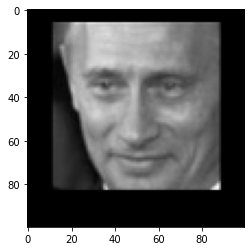

In [166]:
fig, ax = plt.subplots(1)
ax.imshow(output, cmap='gray')

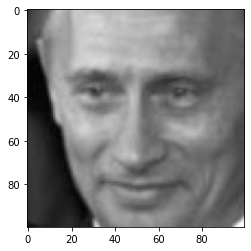

In [174]:
fig, ax = plt.subplots(1)
ax.imshow(img, cmap='gray')

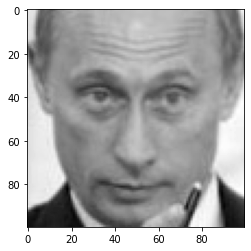

In [179]:
fig, ax = plt.subplots(1)
ax.imshow(img2, cmap='gray')

In [183]:

landmarks2 = extract_face_landmarks(img2)
print(landmarks.shape)
print('\n\nFirst 10 landmarks:\n', landmarks[:10])

(68, 2)


First 10 landmarks:
 [[  9  25]
 [  9  37]
 [ 11  49]
 [ 13  61]
 [ 16  72]
 [ 22  83]
 [ 29  91]
 [ 38  98]
 [ 49 100]
 [ 59 100]]


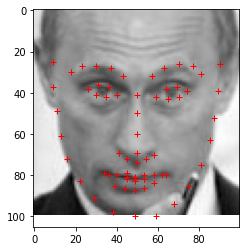

In [184]:
fig, ax = plt.subplots(1)
ax.imshow(img2, cmap='gray')
for i, (x,y) in enumerate(landmarks2):
    ax.plot(x, y, 'r+')
#     ax.annotate(text=str(i), xy=(x,y))

In [193]:
from skimage import data, io, feature, color, exposure
import seaborn as sns

In [187]:
numPoints = 24
radius = 8
lbp = feature.local_binary_pattern(img, numPoints, radius, method="uniform")
lbp2 = feature.local_binary_pattern(img2, numPoints, radius, method="uniform")

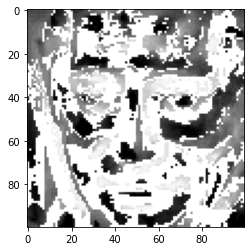

In [188]:
fig, ax = plt.subplots(1)
ax.imshow(lbp, cmap='gray')

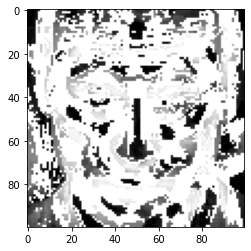

In [189]:
fig, ax = plt.subplots(1)
ax.imshow(lbp2, cmap='gray')

<AxesSubplot:>

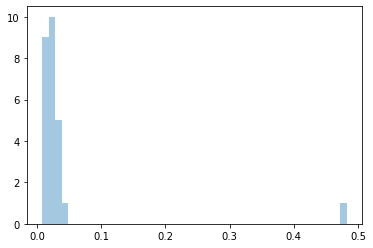

In [195]:
(hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
eps = 1e-6
# normalize the histogram
hist = hist.astype("float")
hist /= (hist.sum() + eps)
sns.distplot(hist, kde=False)

<AxesSubplot:>

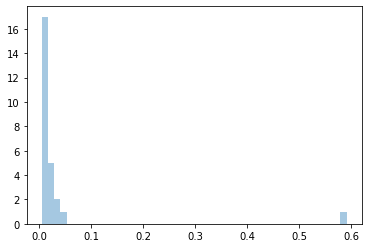

In [196]:
(hist, _) = np.histogram(lbp2.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
eps = 1e-6
# normalize the histogram
hist = hist.astype("float")
hist /= (hist.sum() + eps)
sns.distplot(hist, kde=False)

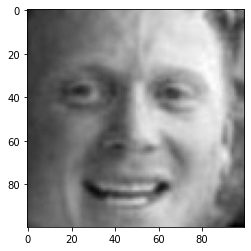

In [197]:
aaron = Path(lfw2_crop, 'Aaron_Guiel', 'Aaron_Guiel_0001.jpg')
img3 = plt.imread(aaron)

fig, ax = plt.subplots(1)
ax.imshow(img3, cmap='gray')

In [217]:
lbp3 = feature.local_binary_pattern(img3, numPoints, radius, method="uniform")

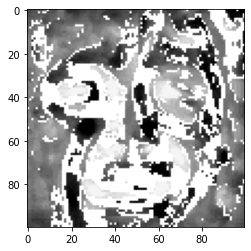

In [218]:
fig, ax = plt.subplots(1)
ax.imshow(lbp3, cmap='gray')

<AxesSubplot:>

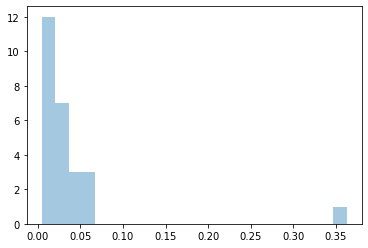

In [219]:
(hist, _) = np.histogram(lbp3.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
eps = 1e-6
# normalize the histogram
hist = hist.astype("float")
hist /= (hist.sum() + eps)
sns.distplot(hist, kde=False)

In [212]:
def lbp2hist(folder, id_):
    path = Path(lfw2_crop, folder, folder + '_' + id_ + '.jpg')
    img = plt.imread(path)
    
    fig, axs = plt.subplots(1,3, figsize=(10,5))
    axs[0].imshow(img, cmap='gray')
    
    lbp = feature.local_binary_pattern(img, numPoints, radius, method="uniform")
    axs[1].imshow(lbp, cmap='gray')
    
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, numPoints + 3), range=(0, numPoints + 2))
    eps = 1e-6
    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    sns.distplot(hist, kde=False, ax=axs[2])
    return hist

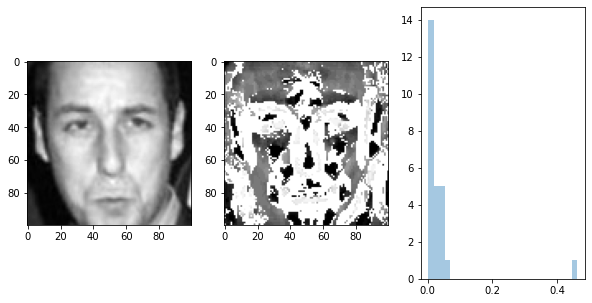

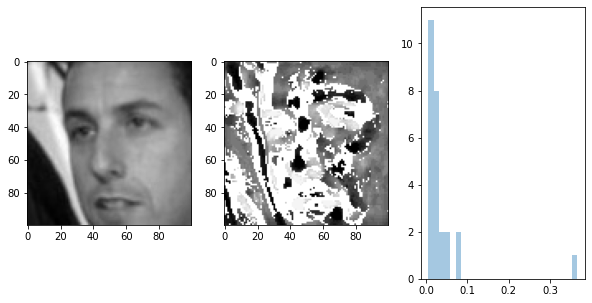

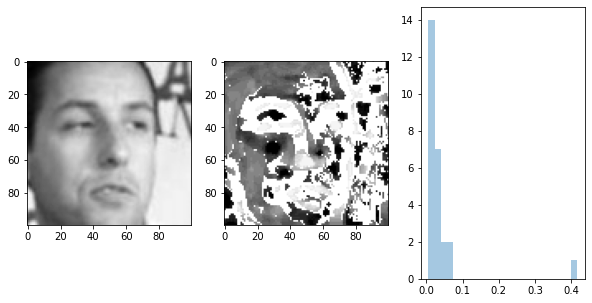

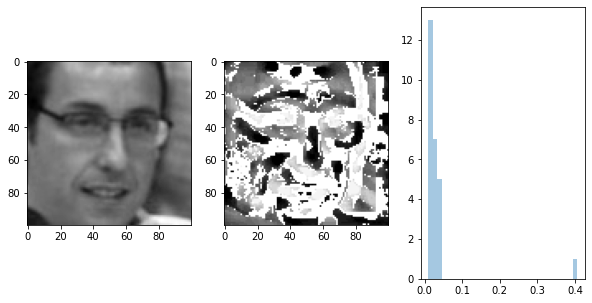

In [213]:
hists = []
folder = 'Adam_Sandler'
for id_ in ['0001', '0002', '0003', '0004']:
    hists.append(lbp2hist(folder, id_))

<AxesSubplot:>

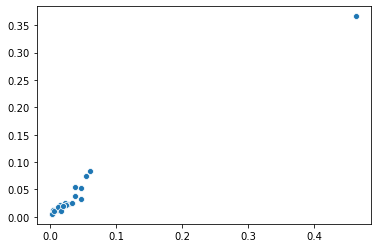

In [214]:
sns.scatterplot(hists[0], hists[1])

<AxesSubplot:>

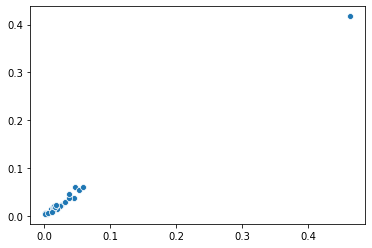

In [215]:
sns.scatterplot(hists[0], hists[2])

<AxesSubplot:>

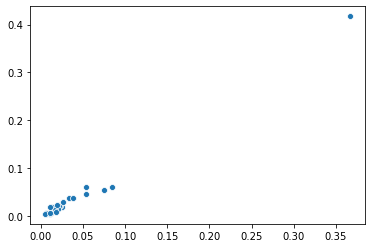

In [216]:
sns.scatterplot(hists[1], hists[2])

In [207]:
from scipy.stats import kstest

<AxesSubplot:>

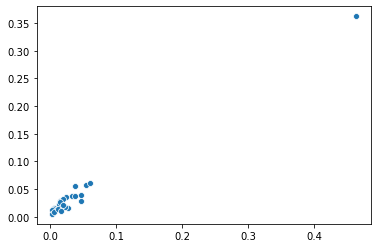

In [221]:

sns.scatterplot(hists[0], hist)

<AxesSubplot:>

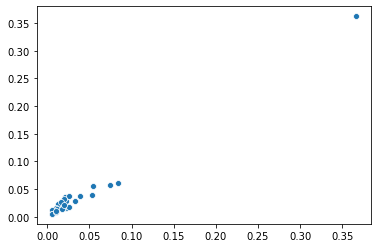

In [222]:

sns.scatterplot(hists[1], hist)

<AxesSubplot:>

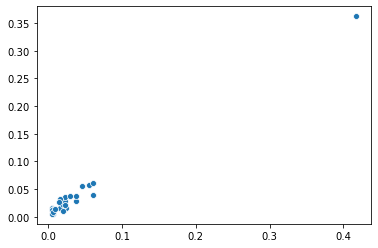

In [223]:

sns.scatterplot(hists[2], hist)